<a href="https://colab.research.google.com/github/kunj1210/Pneumonia_Detection/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
    BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
)

from keras.applications.densenet import DenseNet121

import torch.nn as nn
from keras.layers.pooling.base_pooling2d import Pooling2D

from tensorflow.python.util.tf_export import keras_export
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import ResNet50V2
from keras import backend as K
import tensorflow as tf
import tensorflow
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet import ResNet
from keras.applications.xception import Xception
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
import keras.backend as k
from sklearn.utils import shuffle
import io
from PIL import Image as pil_image

Loading Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.listdir()

['6363Project.ipynb',
 'CSE-6363-003_004-project-Fall-2022 .pdf',
 'Team9Review1.docx',
 'requirement.docx',
 'Data.zip',
 'Data Preprocessing .ipynb',
 '.DS_Store',
 '.ipynb_checkpoints',
 'chest_xray',
 'models',
 'weights.h5']

In [ ]:
%cd /content/drive/MyDrive/UTA/Fall22/6363/Project

/content/drive/MyDrive/UTA/Fall22/6363/Project


In [ ]:
data_dir = 'chest_xray'

training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
os.listdir(data_dir)
os.listdir(training_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

Training Dataset Image

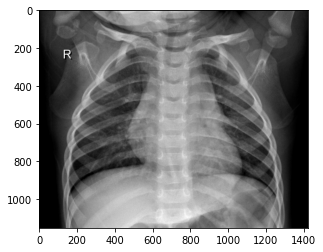

In [ ]:
image_plt = plt.imread(os.path.join(training_dir,'NORMAL/IM-0117-0001.jpeg'))
plt.imshow(image_plt,cmap='gray')

Exploratory data Analysis​

In [ ]:
print("Training Set:")
print("# of Pneumonia case:",len(os.listdir(os.path.join(training_dir,'PNEUMONIA'))))
print("# of Normal case:",len(os.listdir(os.path.join(training_dir,'NORMAL'))))
print("Validation Set:")
print("# of Pneumonia case:",len(os.listdir(os.path.join(validation_dir,'PNEUMONIA'))))
print("# of Normal case:",len(os.listdir(os.path.join(validation_dir,'NORMAL'))))
print("Test Set:")
print("# of Pneumonia case:",len(os.listdir(os.path.join(test_dir,'PNEUMONIA'))))
print("# of Normal case:",len(os.listdir(os.path.join(test_dir,'NORMAL'))))

Training Set:
# of Pneumonia case: 3895
# of Normal case: 1341
Validation Set:
# of Pneumonia case: 8
# of Normal case: 8
Test Set:
# of Pneumonia case: 390
# of Normal case: 234


Images of pneumonia cases

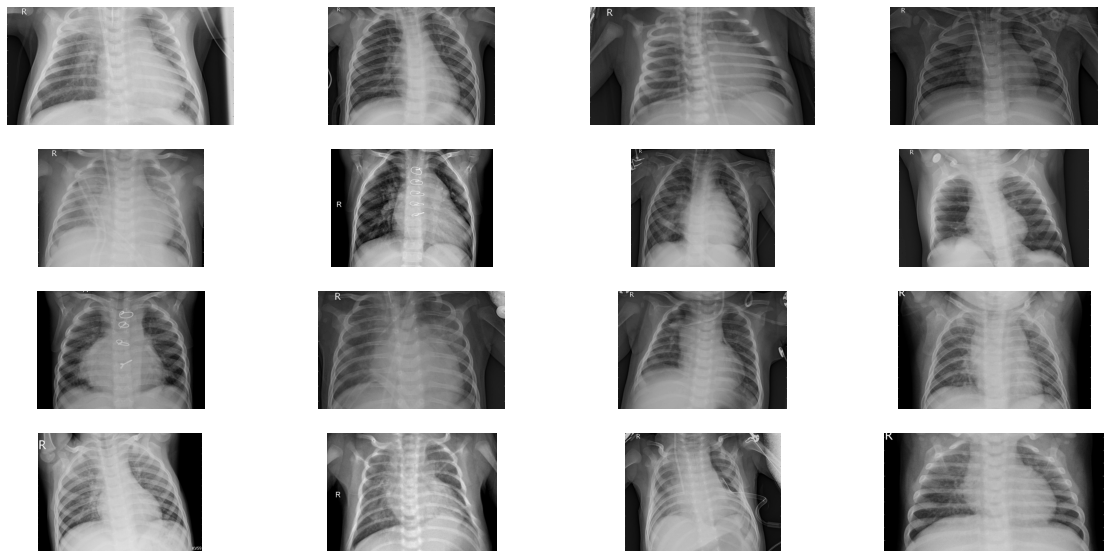

In [ ]:
plt.figure(figsize=(20,10))
pneumonia_path = os.path.join(training_dir,'PNEUMONIA')

for i in range(16):
  plt.subplot(4,4,i+1)
  img = plt.imread(os.path.join(pneumonia_path,os.listdir(pneumonia_path)[i]))
  plt.imshow(img,cmap='gray')
  plt.axis('off')

Image Preprocessing Using Keras ImageDataGenerator

In [ ]:
from keras_preprocessing.image import image_data_generator
image_data_generator = ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 0,
    shear_range = 0.1,
    horizontal_flip = True,
    samplewise_center = True,
    samplewise_std_normalization = True
    
)

Applying Image Preprocessing on Training, Validation, Test Dataset

In [ ]:
training = image_data_generator.flow_from_directory(training_dir, 
                                            batch_size=10, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(350, 350))
validation = image_data_generator.flow_from_directory(validation_dir, 
                                            batch_size=1, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(350, 350))
test = image_data_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(350, 350))

Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Preprocessed Image from Training Dataset

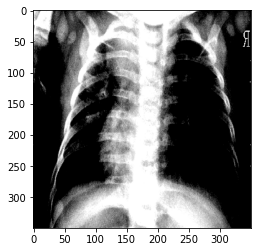

In [ ]:
generated_image, label = training.__getitem__(0)
plt.imshow(generated_image[0])

In [ ]:
num_pneumonia = len(os.listdir(os.path.join(training_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(training_dir, 'NORMAL')))

In [ ]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


Sequential Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(350, 350, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(350, 350, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 348, 348, 32)      896       
                                                                 
 batch_normalization_80 (Bat  (None, 348, 348, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_82 (Conv2D)          (None, 346, 346, 32)      9248      
                                                                 
 batch_normalization_81 (Bat  (None, 346, 346, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 173, 173, 32)     0         
 ng2D)                                                           
                                                     

In [ ]:
r = model.fit(
    training, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=16,
)

Epoch 1/10
100/100 [==============================] - 41s 398ms/step - loss: 1.5255 - accuracy: 0.8323 - val_loss: 14.1739 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 42s 418ms/step - loss: 0.2671 - accuracy: 0.8760 - val_loss: 1.3344 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 39s 388ms/step - loss: 0.1654 - accuracy: 0.8980 - val_loss: 0.8876 - val_accuracy: 0.5625
Epoch 4/10
100/100 [==============================] - 39s 393ms/step - loss: 0.1826 - accuracy: 0.8544 - val_loss: 5.3976 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 39s 392ms/step - loss: 0.1175 - accuracy: 0.8845 - val_loss: 0.5837 - val_accuracy: 0.5625
Epoch 6/10
100/100 [==============================] - 51s 511ms/step - loss: 0.0766 - accuracy: 0.9340 - val_loss: 1.7602 - val_accuracy: 0.5625
Epoch 7/10
100/100 [==============================] - 45s 447ms/step - loss: 0.0715 - accuracy: 0.9330 - val_loss: 1.8281 - val_a

Text(0.5, 1.0, 'Accuracy Evolution')

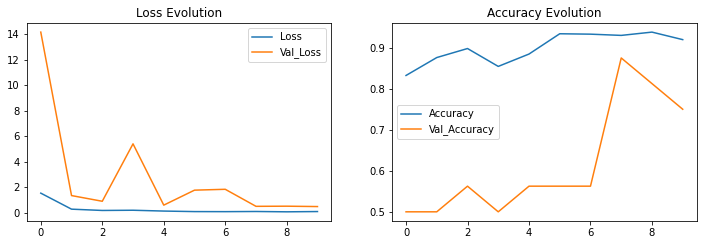

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 24s 39ms/step - loss: 0.6615 - accuracy: 0.7981
Test Accuracy: 79.81%
524/524 [==============================] - 203s 386ms/step - loss: 0.1094 - accuracy: 0.9650
Train Accuracy: 96.50%


In [ ]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

624/624 [==============================] - 24s 37ms/step
[[ 58 176]
 [101 289]]


,0,1,accuracy,macro avg,weighted avg
precision,0.364780,0.621505,0.55609,0.493143,0.525233
recall,0.247863,0.741026,0.55609,0.494444,0.556090
f1-score,0.295165,0.676023,0.55609,0.485594,0.533202
support,234.000000,390.000000,0.55609,624.000000,624.000000


In [ ]:
#
base_model = ResNet50V2(input_shape=(350, 350, 3), include_top=False, weights='imagenet', pooling='avg')


model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(350, 350, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model1 = ResNet50V2(include_top=False, weights=None, input_tensor=model.output)
x = model1.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="relu")(x)

model1 = Model(model1.input, predictions)
model1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model1.fit(
    training, 
    epochs=9,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=10,
)

(None, 2048)
Epoch 1/9
100/100 [==============================] - 46s 392ms/step - loss: 2.8020 - accuracy: 0.6900 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/9
100/100 [==============================] - 40s 397ms/step - loss: 2.8708 - accuracy: 0.7460 - val_loss: 9.1495 - val_accuracy: 0.4000
Epoch 3/9
100/100 [==============================] - 38s 383ms/step - loss: 2.9834 - accuracy: 0.7370 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/9
100/100 [==============================] - 44s 441ms/step - loss: 3.1649 - accuracy: 0.7210 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/9
100/100 [==============================] - 39s 390ms/step - loss: 2.8473 - accuracy: 0.7490 - val_loss: 4.5748 - val_accuracy: 0.7000
Epoch 6/9
100/100 [==============================] - 42s 420ms/step - loss: 3.0068 - accuracy: 0.7349 - val_loss: 4.5748 - val_accuracy: 0.7000
Epoch 7/9
100/100 [==============================] - 39s 384ms/step - loss: 3.0401 - accuracy: 0.7320 - val_loss: 7.6246 - 

Text(0.5, 1.0, 'Accuracy Evolution')

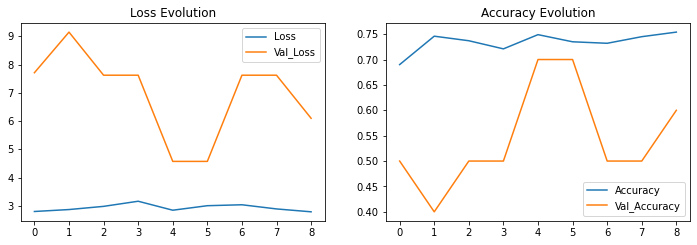

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model1.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model1.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 28s 45ms/step - loss: 5.7185 - accuracy: 0.6250
Test Accuracy: 62.50%
524/524 [==============================] - 188s 359ms/step - loss: 3.9084 - accuracy: 0.7437
Train Accuracy: 74.37%


ResNet50V2 and Sequential Model

In [ ]:
base_model = ResNet50V2(include_top=False, weights="imagenet", pooling="max",input_shape=(350, 350, 3))
base_model.trainable = True
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Reshape((2,2,512)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(tf.keras.layers.Conv2D(264, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(264, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=.2))  
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=.2))
model.add(tf.keras.layers.Dense(1, activation='softmax')) 
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    training, 
    epochs=15,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=5,
)

94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/15
100/100 [==============================] - 939s 9s/step - loss: 0.2025 - accuracy: 0.7520 - val_loss: 55904.6484 - val_accuracy: 0.4000
Epoch 2/15
100/100 [==============================] - 923s 9s/step - loss: 0.1521 - accuracy: 0.7460 - val_loss: 363.1740 - val_accuracy: 0.6000
Epoch 3/15
100/100 [==============================] - 925s 9s/step - loss: 0.1493 - accuracy: 0.7320 - val_loss: 7.4305 - val_accuracy: 0.8000
Epoch 4/15
100/100 [==============================] - 928s 9s/step - loss: 0.1167 - accuracy: 0.7390 - val_loss: 0.6291 - val_accuracy: 0.4000
Epoch 5/15
100/100 [==============================] - 929s 9s/step - loss: 0.1539 - accuracy: 0.7510 - val_loss: 12.0884 - val_accuracy: 0.6000
Epoch 6/15
100/100 [==============================] - 926s 9s/step - loss: 0.1206 - accuracy: 0.7289 - val_loss: 2.6090 - val_accuracy: 0.4000
Epoch 7/15
100/100 [==============================] - 930s 9s/step - l

In [ ]:
model.summary()

Text(0.5, 1.0, 'Accuracy Evolution')

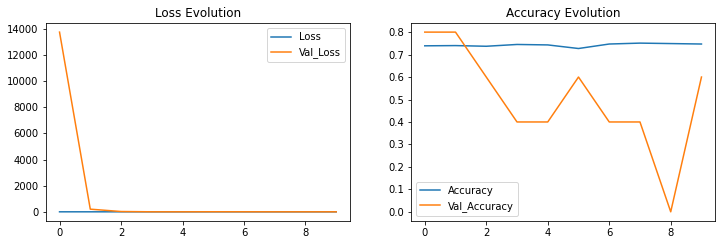

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 26s 42ms/step - loss: 2.4891 - accuracy: 0.6250
Test Accuracy: 62.50%
524/524 [==============================] - 202s 385ms/step - loss: 2.8976 - accuracy: 0.7439
Train Accuracy: 74.39%


DenseNet121

In [ ]:
base_model = DenseNet121(input_shape=(350, 350, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 356, 356, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 175, 175, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 350, 350, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [ ]:
# model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    training, 
    epochs=15,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=16,
)

Epoch 1/15
100/100 [==============================] - 68s 461ms/step - loss: 0.1355 - accuracy: 0.8570 - val_loss: 4.1914 - val_accuracy: 0.5625
Epoch 2/15
100/100 [==============================] - 48s 477ms/step - loss: 0.0616 - accuracy: 0.9388 - val_loss: 28.5449 - val_accuracy: 0.5000
Epoch 3/15
100/100 [==============================] - 42s 423ms/step - loss: 0.0482 - accuracy: 0.9490 - val_loss: 2.7373 - val_accuracy: 0.5625
Epoch 4/15
100/100 [==============================] - 44s 435ms/step - loss: 0.0642 - accuracy: 0.9347 - val_loss: 1.0716 - val_accuracy: 0.8125
Epoch 5/15
100/100 [==============================] - 43s 423ms/step - loss: 0.0765 - accuracy: 0.9227 - val_loss: 3.0639 - val_accuracy: 0.5000
Epoch 6/15
100/100 [==============================] - 44s 433ms/step - loss: 0.0606 - accuracy: 0.9310 - val_loss: 0.4295 - val_accuracy: 0.8750
Epoch 7/15
100/100 [==============================] - 44s 442ms/step - loss: 0.0457 - accuracy: 0.9550 - val_loss: 0.3397 - val_a

Text(0.5, 1.0, 'Accuracy Evolution')

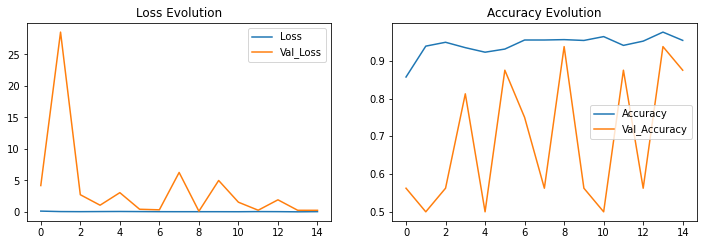

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 27s 43ms/step - loss: 1.3243 - accuracy: 0.7692
Test Accuracy: 76.92%
524/524 [==============================] - 190s 362ms/step - loss: 0.1480 - accuracy: 0.9435
Train Accuracy: 94.35%


In [ ]:
predicted_vals = model.predict(test, steps=len(test))

624/624 [==============================] - 26s 39ms/step


In [ ]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))


[[ 34 200]
 [ 87 303]]


,0,1,accuracy,macro avg,weighted avg
precision,0.280992,0.602386,0.540064,0.441689,0.481863
recall,0.145299,0.776923,0.540064,0.461111,0.540064
f1-score,0.191549,0.678611,0.540064,0.435080,0.495963
support,234.000000,390.000000,0.540064,624.000000,624.000000


In [ ]:
res_model = ResNet50(input_shape=(350, 350, 3 ), include_top=False, weights='imagenet', pooling='max')

res_model.summary()

x = res_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="relu")(x)

model = Model(inputs=res_model.input, outputs=predictions)
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    training, 
    epochs=15,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=10,
)

Epoch 1/15
100/100 [==============================] - 336s 3s/step - loss: 3.0131 - accuracy: 0.7290 - val_loss: 9.1495 - val_accuracy: 0.4000
Epoch 2/15
100/100 [==============================] - 266s 3s/step - loss: 3.3351 - accuracy: 0.7060 - val_loss: 6.0997 - val_accuracy: 0.6000
Epoch 3/15
100/100 [==============================] - 206s 2s/step - loss: 2.7565 - accuracy: 0.7570 - val_loss: 1.0992 - val_accuracy: 0.4000
Epoch 4/15
100/100 [==============================] - 196s 2s/step - loss: 3.0174 - accuracy: 0.7340 - val_loss: 0.9593 - val_accuracy: 0.6000
Epoch 5/15
100/100 [==============================] - 156s 2s/step - loss: 2.7679 - accuracy: 0.7560 - val_loss: 0.9311 - val_accuracy: 0.5000
Epoch 6/15
100/100 [==============================] - 135s 1s/step - loss: 3.0401 - accuracy: 0.7320 - val_loss: 2.3795 - val_accuracy: 0.5000
Epoch 7/15
100/100 [==============================] - 119s 1s/step - loss: 2.9380 - accuracy: 0.7410 - val_loss: 6.1169 - val_accuracy: 0.6000

Text(0.5, 1.0, 'Accuracy Evolution')

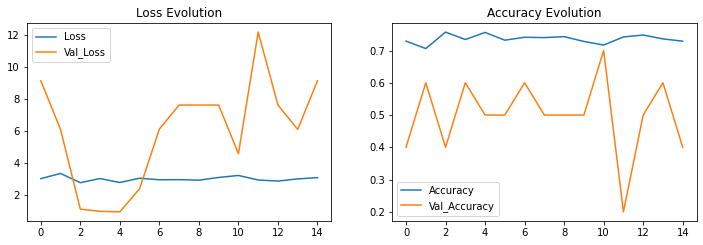

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 202s 324ms/step - loss: 5.7186 - accuracy: 0.6250
Test Accuracy: 62.50%
524/524 [==============================] - 275s 526ms/step - loss: 3.9055 - accuracy: 0.7439
Train Accuracy: 74.39%
624/624 [==============================] - 34s 54ms/step - loss: 5.7186 - accuracy: 0.6250
Test Accuracy: 62.50%
524/524 [==============================] - 214s 409ms/step - loss: 3.9055 - accuracy: 0.7439
Train Accuracy: 74.39%


In [ ]:
res_modelv2 = ResNet50V2(input_shape=(350, 350, 3), include_top=False, weights='imagenet')

res_modelv2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 356, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 175, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
#res_modelv2 = ResNet50V2(include_top=False, weights='imagenet')
x = res_modelv2.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="relu")(x)

model = Model(inputs=res_modelv2.input, outputs=predictions)

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    training, 
    epochs=9,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=10,
)

Epoch 1/9
100/100 [==============================] - 56s 502ms/step - loss: 2.4577 - accuracy: 0.5600 - val_loss: 4.5748 - val_accuracy: 0.7000
Epoch 2/9
100/100 [==============================] - 47s 471ms/step - loss: 0.3632 - accuracy: 0.6300 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/9
100/100 [==============================] - 47s 468ms/step - loss: 0.3020 - accuracy: 0.7710 - val_loss: 1.8217 - val_accuracy: 0.7000
Epoch 4/9
100/100 [==============================] - 53s 530ms/step - loss: 0.2611 - accuracy: 0.7300 - val_loss: 1.8819 - val_accuracy: 0.6000


KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Accuracy Evolution')

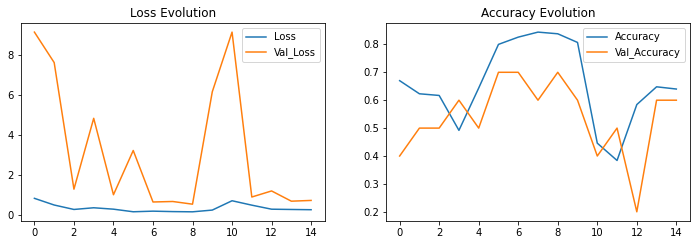

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(training)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 30s 48ms/step - loss: 5.7185 - accuracy: 0.6250
Test Accuracy: 62.50%
524/524 [==============================] - 217s 413ms/step - loss: 3.9055 - accuracy: 0.7439
Train Accuracy: 74.39%


Model Accuracy Graph


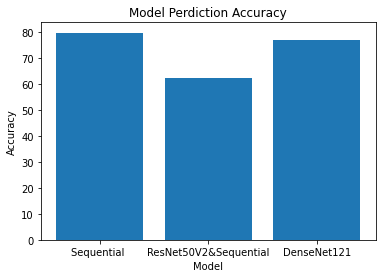

In [ ]:
print("Model Accuracy Graph")
model = ["Sequential ","ResNet50V2&Sequential","DenseNet121"]
plt.figure()
plt.title("Model Perdiction Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.bar(model,[79.81,62.50,76.92])
plt.show()